# Pymaceuticals
```{admonition} Revised
02 Nov 2022
```

---

## Programming Environment

In [1]:
import pandas            as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt

import scipy
import scipy.stats       as st

import datetime
from   importlib.metadata import version
import os
import platform as p
import sys

pad = 20
print(  f"\n{'Executed' : <{pad}} : {datetime.datetime.now().astimezone().strftime('%Y-%m-%d %H:%M:%S %z %Z')}"
        f"\n{'Platform' : <{pad}} : {p.platform(aliased = False, terse = False)}"
        f"\n{'Conda'    : <{pad}} : {os.environ['CONDA_DEFAULT_ENV'] or sys.executable.split('/')[-3]}"
        f"\n{'Python'   : <{pad}} : {p.python_implementation()} {p.python_version()} {sys.executable}")
print(*[f'{name : <{pad}} : {version(name)}'
        for name in ['Matplotlib', 'NumPy', 'Pandas', 'SciPy']], sep = '\n')


Executed             : 2023-09-04 17:47:01 -0400 EDT
Platform             : macOS-13.5.1-arm64-arm-64bit
Conda                : ml
Python               : CPython 3.11.5 /Users/df/anaconda3/envs/ml/bin/python
Matplotlib           : 3.7.2
NumPy                : 1.23.5
Pandas               : 2.1.0
SciPy                : 1.11.2


---

```python
mouse_metadata = pd.read_csv('Mouse_metadata.csv')
study_results  = pd.read_csv('Study_results.csv')

study_data_complete = pd.merge(left =study_results,
                               right=mouse_metadata,
                               how  ='left',
                               on   ='Mouse ID')

#####
#
# Data Cleaning - duplicated points in time
#
#####

# How many mice are there (pre clean)?
#   249
mouse_metadata['Mouse ID'].unique().size

# Do any mice have duplicated data at a given point in time?
#   g989
duplicate_mouse_ids = study_data_complete.loc[
  study_data_complete.duplicated(subset=['Mouse ID', 'Timepoint'],
                                 keep  =False),
  'Mouse ID'
].unique()

duplicate_mouse_data = study_data_complete[
  study_data_complete['Mouse ID'] == 'g989'
]

clean_study_data_complete = study_data_complete[
  study_data_complete['Mouse ID'] != 'g989'
]

# How many mice are there (post clean)?
#   248
clean_study_data_complete['Mouse ID'].unique().size

#####
#
# Summary Statistics - Tumor Volume
#
#####

summary_table = clean_study_data_complete \
  .groupby(by=['Drug Regimen']) \
  .agg({
    'Tumor Volume (mm3)' : [
      'mean',
      'median',
      'var',
      'std',
      'sem'
    ],
  })

#####
#
# Bar Plot
#
#####

clean_study_data_complete['Drug Regimen'] \
  .value_counts() \
  .plot(kind  ='bar',
        xlabel='Drug Regimen',
        ylabel='Number of Mice Tested',
        width =0.8)
plt.xticks(ha      ='right',
           rotation=45);

#####
#
# Pie Plot
#
#####

clean_study_data_complete.Sex \
  .value_counts() \
  .plot(kind='pie',
        autopct='%1.1f%%');

#####
#
# IQR
#
#####

max_tumor = clean_study_data_complete \
  .groupby(by=['Mouse ID'])['Timepoint'] \
  .max() \
  .reset_index()

merged_data = max_tumor.merge(right=clean_study_data_complete,
                              on   =['Mouse ID', 'Timepoint'],
                              how  ='left')

treatment_list = [
  'Capomulin',
  'Ramicane',
  'Infubinol',
  'Ceftamin',
]

tumor_vol_list = []
for drug in treatment_list:

  final_tumor_vol = merged_data.loc[
    merged_data['Drug Regimen'] == drug,
    'Tumor Volume (mm3)'
  ]
  tumor_vol_list.append(final_tumor_vol)

  quartiles = final_tumor_vol.quantile([0.25, 0.5, 0.75])
  lowerq    = quartiles[0.25]
  upperq    = quartiles[0.75]
  iqr       = upperq - lowerq
  lower_bound = lowerq - (1.5*iqr)
  upper_bound = upperq + (1.5*iqr)
  outliers    = final_tumor_vol[
      (final_tumor_vol < lower_bound)
    | (final_tumor_vol > upper_bound)
  ]

  print(f"{drug}'s potential outliers: {outliers}")

#####
#
# Box Plot
#
#####

plt.boxplot(x         =tumor_vol_list,
            flierprops={'markerfacecolor' : 'red',
                        'markersize'      : 12},
            labels    =treatment_list)
plt.ylabel('Final Tumor Volume (mm3)');

#####
#
# Line Plot
#
#####

capomulin_table = clean_study_data_complete[
  clean_study_data_complete['Drug Regimen'] == 'Capomulin'
]
mousedata = capomulin_table[
  capomulin_table['Mouse ID'] == 'l509'
]

plt.plot(mousedata['Timepoint'],
         mousedata['Tumor Volume (mm3)'])
plt.xlabel('Timepoint (days)')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Capomulin treatment of mouse l509');

#####
#
# Scatter Plot
#
#####

capomulin_average = capomulin_table.groupby(by=['Mouse ID']).mean(numeric_only=True)

plt.scatter(x=capomulin_average['Weight (g)'],
            y=capomulin_average['Tumor Volume (mm3)'])
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)');

#####
#
# Correlation
#
#####

corr = st.pearsonr(x=capomulin_average['Weight (g)'],
                   y=capomulin_average['Tumor Volume (mm3)'])

#####
#
# Linear Regression
#
#####

model = st.linregress(x=capomulin_average['Weight (g)'],
                      y=capomulin_average['Tumor Volume (mm3)'])
y     = capomulin_average['Weight (g)'] * model[0] + model[1]

plt.scatter(x=capomulin_average['Weight (g)'],
            y=capomulin_average['Tumor Volume (mm3)'])
plt.plot(capomulin_average['Weight (g)'],
         y,
         color='red')
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)');
```

---

#### Data Cleaning - duplicated points in time

In [2]:
mouse_metadata = pd.read_csv('data/Mouse_metadata.csv')
mouse_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Mouse ID      249 non-null    object
 1   Drug Regimen  249 non-null    object
 2   Sex           249 non-null    object
 3   Age_months    249 non-null    int64 
 4   Weight (g)    249 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 9.9+ KB


In [3]:
mouse_metadata

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16
...,...,...,...,...,...
244,z314,Stelasyn,Female,21,28
245,z435,Propriva,Female,12,26
246,z581,Infubinol,Female,24,25
247,z795,Naftisol,Female,13,29


In [4]:
study_results = pd.read_csv('data/Study_results.csv')
study_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893 entries, 0 to 1892
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mouse ID            1893 non-null   object 
 1   Timepoint           1893 non-null   int64  
 2   Tumor Volume (mm3)  1893 non-null   float64
 3   Metastatic Sites    1893 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 59.3+ KB


In [5]:
study_results

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.000000,0
1,f932,0,45.000000,0
2,g107,0,45.000000,0
3,a457,0,45.000000,0
4,c819,0,45.000000,0
...,...,...,...,...
1888,r944,45,41.581521,2
1889,u364,45,31.023923,3
1890,p438,45,61.433892,1
1891,x773,45,58.634971,4


In [6]:
study_data_complete = pd.merge(left =study_results,
                               right=mouse_metadata,
                               how  ='left',
                               on   ='Mouse ID')
study_data_complete

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [7]:
# How many mice are there (pre clean)?
#   249
mouse_metadata['Mouse ID'].unique().size

249

In [8]:
# Do any mice have duplicated data at a given point in time?
#   g989
duplicate_mouse_ids = study_data_complete.loc[
  study_data_complete.duplicated(subset=['Mouse ID', 'Timepoint'],
                                 keep  =False),
  'Mouse ID'
].unique()
duplicate_mouse_ids

array(['g989'], dtype=object)

In [9]:
duplicate_mouse_data = study_data_complete[
  study_data_complete['Mouse ID'] == 'g989'
]
duplicate_mouse_data

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [10]:
clean_study_data_complete = study_data_complete[
  study_data_complete['Mouse ID'] != 'g989'
]
clean_study_data_complete
# ALTERNATIVE
# study_data_complete[
#   study_data_complete['Mouse ID'].isin(duplicate_mouse_ids) == False
# ]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [11]:
# How many mice are there (post clean)?
#   248
clean_study_data_complete['Mouse ID'].unique().size

248

#### Summary Statistics - Tumor Volume

In [12]:
summary_table = clean_study_data_complete \
  .groupby(by=['Drug Regimen']) \
  .agg({
    'Tumor Volume (mm3)' : [
      'mean',
      'median',
      'var',
      'std',
      'sem'
    ],
  })
summary_table
# WORSE ALTERNATIVE
# df        = clean_study_data_complete
# b         = 'Drug Regimen'
# col       = 'Tumor Volume (mm3)'
#
# means     = df.groupby(by=[b]).mean(numeric_only=True)[col]
# medians   = df.groupby(by=[b]).median(numeric_only=True)[col]
# variances = df.groupby(by=[b]).var(numeric_only=True)[col]
# sds       = df.groupby(by=[b]).std(numeric_only=True)[col]
# sems      = df.groupby(by=[b]).sem(numeric_only=True)[col]
#
# summary_table = pd.DataFrame({
#   'Mean Tumor Volume'     : means,
#   'Median Tumor Volume'   : medians,
#   'Tumor Volume Variance' : variances,
#   'Tumor Volume Std Dev'  : sds,
#   'Tumor Volume Std Err'  : sems,
# })

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

#### Bar Plot

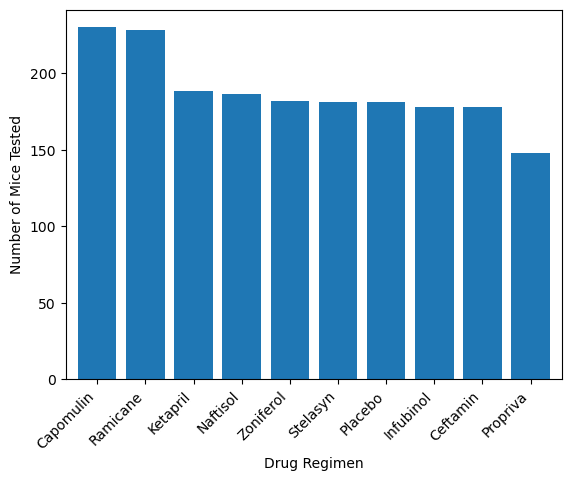

In [13]:
clean_study_data_complete['Drug Regimen'] \
  .value_counts() \
  .plot(kind  ='bar',
        xlabel='Drug Regimen',
        ylabel='Number of Mice Tested',
        width =0.8)
plt.xticks(ha      ='right',
           rotation=45);
# ALTERNATIVE
# counts = clean_study_data_complete['Drug Regimen'].value_counts()
# plt.bar(x     =counts.index.values,
#         height=counts.values,
#         width =0.8)
# plt.xlabel('Drug Regimen')
# plt.xticks(rotation=90)
# plt.ylabel('Number of Mice Tested');

#### Pie Plot

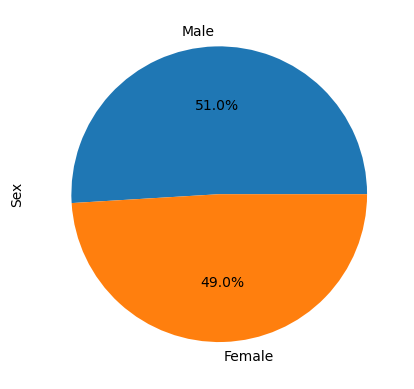

In [14]:
clean_study_data_complete.Sex \
  .value_counts() \
  .plot(kind='pie',
        autopct='%1.1f%%');
# ALTERNATIVE
# xcounts = clean_study_data_complete.Sex.value_counts()
# plt.pie(x      =counts.values,
#         labels =counts.index.values,
#         autopct='%1.1f%%')
# plt.ylabel('Sex');

#### IQR

In [15]:
max_tumor = clean_study_data_complete \
  .groupby(by=['Mouse ID'])['Timepoint'] \
  .max() \
  .reset_index()
max_tumor

,Mouse ID,Timepoint
0,a203,45
1,a251,45
2,a262,45
3,a275,45
4,a366,30
...,...,...
243,z435,10
244,z578,45
245,z581,45
246,z795,45


In [16]:
merged_data = max_tumor.merge(right=clean_study_data_complete,
                              on   =['Mouse ID', 'Timepoint'],
                              how  ='left')
merged_data

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,a203,45,67.973419,2,Infubinol,Female,20,23
1,a251,45,65.525743,1,Infubinol,Female,21,25
2,a262,45,70.717621,4,Placebo,Female,17,29
3,a275,45,62.999356,3,Ceftamin,Female,20,28
4,a366,30,63.440686,1,Stelasyn,Female,16,29
...,...,...,...,...,...,...,...,...
243,z435,10,48.710661,0,Propriva,Female,12,26
244,z578,45,30.638696,0,Ramicane,Male,11,16
245,z581,45,62.754451,3,Infubinol,Female,24,25
246,z795,45,65.741070,3,Naftisol,Female,13,29


In [42]:
treatment_list = [
  'Capomulin',
  'Ramicane',
  'Infubinol',
  'Ceftamin',
]

tumor_vol_list = []
for drug in treatment_list:
  final_tumor_vol = merged_data.loc[
    merged_data['Drug Regimen'] == drug,
    'Tumor Volume (mm3)'
  ]
  tumor_vol_list.append(final_tumor_vol)

  quartiles = final_tumor_vol.quantile([0.25, 0.5, 0.75])
  lowerq    = quartiles[0.25]
  upperq    = quartiles[0.75]
  iqr       = upperq - lowerq
  lower_bound = lowerq - (1.5*iqr)
  upper_bound = upperq + (1.5*iqr)
  outliers    = final_tumor_vol[
      (final_tumor_vol < lower_bound)
    | (final_tumor_vol > upper_bound)
  ]

  print(f"{drug}'s potential outliers: {outliers}")

Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


#### Box Plot

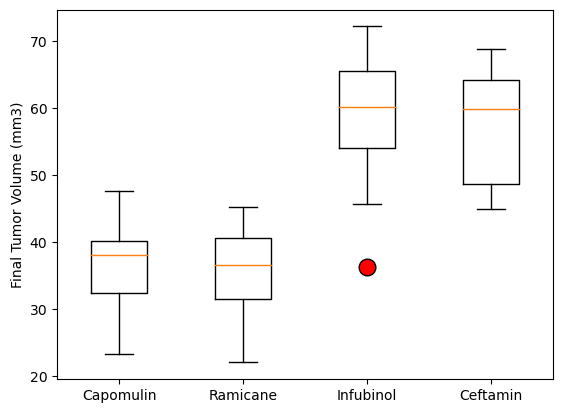

In [21]:
plt.boxplot(x         =tumor_vol_list,
            flierprops={'markerfacecolor' : 'red',
                        'markersize'      : 12},
            labels    =treatment_list)
plt.ylabel('Final Tumor Volume (mm3)');

#### Line Plot

In [23]:
capomulin_table = clean_study_data_complete[
  clean_study_data_complete['Drug Regimen'] == 'Capomulin'
]
capomulin_table

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
226,j246,0,45.000000,0,Capomulin,Female,21,21
227,r554,0,45.000000,0,Capomulin,Female,8,17
228,s185,0,45.000000,0,Capomulin,Female,3,17
229,b742,0,45.000000,0,Capomulin,Male,7,21
...,...,...,...,...,...,...,...,...
1854,s710,45,40.728578,1,Capomulin,Female,1,23
1859,j119,45,38.125164,1,Capomulin,Female,7,23
1878,i557,45,47.685963,1,Capomulin,Female,1,24
1888,r944,45,41.581521,2,Capomulin,Male,12,25


In [24]:
mousedata = capomulin_table[
  capomulin_table['Mouse ID'] == 'l509'
]
mousedata

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
231,l509,0,45.000000,0,Capomulin,Male,17,21
253,l509,5,45.851193,0,Capomulin,Male,17,21
539,l509,10,46.759074,0,Capomulin,Male,17,21
881,l509,15,47.488599,1,Capomulin,Male,17,21
982,l509,20,48.070452,2,Capomulin,Male,17,21
1146,l509,25,44.006257,2,Capomulin,Male,17,21
1414,l509,30,44.708055,2,Capomulin,Male,17,21
1499,l509,35,40.207288,2,Capomulin,Male,17,21
1723,l509,40,40.770813,2,Capomulin,Male,17,21
1771,l509,45,41.483008,3,Capomulin,Male,17,21


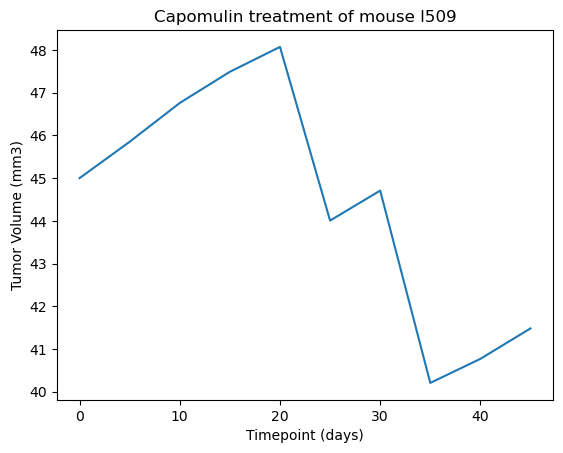

In [27]:
plt.plot(mousedata['Timepoint'],
         mousedata['Tumor Volume (mm3)'])
plt.xlabel('Timepoint (days)')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Capomulin treatment of mouse l509');

#### Scatter Plot

In [29]:
capomulin_average = capomulin_table.groupby(by=['Mouse ID']).mean(numeric_only=True)
capomulin_average

,Timepoint,Tumor Volume (mm3),Metastatic Sites,Age_months,Weight (g)
Mouse ID,,,,,
b128,22.5,41.963636,0.70,9.0,22.0
b742,22.5,40.083699,0.00,7.0,21.0
f966,10.0,36.505973,0.00,16.0,17.0
g288,22.5,41.990097,0.80,3.0,19.0
g316,22.5,44.613344,1.00,22.0,22.0
i557,22.5,44.805810,0.20,1.0,24.0
i738,22.5,39.141053,0.60,23.0,20.0
j119,22.5,44.465236,0.60,7.0,23.0
j246,17.5,43.216925,0.25,21.0,21.0


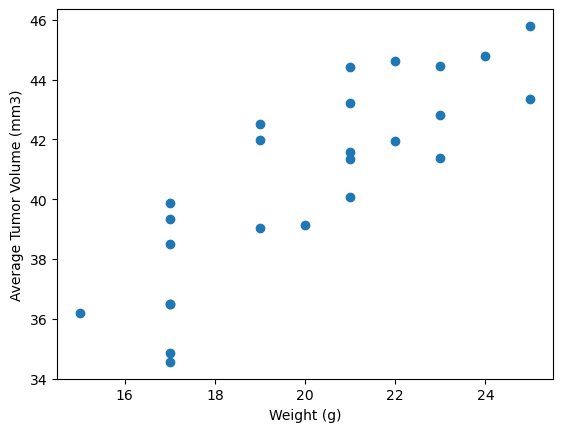

In [31]:
plt.scatter(x=capomulin_average['Weight (g)'],
            y=capomulin_average['Tumor Volume (mm3)'])
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)');

#### Correlation

In [35]:
corr = st.pearsonr(x=capomulin_average['Weight (g)'],
                   y=capomulin_average['Tumor Volume (mm3)'])
corr

PearsonRResult(statistic=0.841936342469472, pvalue=1.3225722434712483e-07)

#### Linear Regression

In [38]:
model = st.linregress(x=capomulin_average['Weight (g)'],
                      y=capomulin_average['Tumor Volume (mm3)'])
model

LinregressResult(slope=0.9544396890241047, intercept=21.55216053268501, rvalue=0.841936342469472, pvalue=1.3225722434712478e-07, stderr=0.12754359033201326, intercept_stderr=2.590987686768347)

In [39]:
y = capomulin_average['Weight (g)'] * model[0] + model[1]
y

Mouse ID
b128    42.549834
b742    41.595394
f966    37.777635
g288    39.686515
g316    42.549834
i557    44.458713
i738    40.640954
j119    43.504273
j246    41.595394
l509    41.595394
l897    39.686515
m601    37.777635
m957    39.686515
r157    45.413153
r554    37.777635
r944    45.413153
s185    37.777635
s710    43.504273
t565    37.777635
u364    37.777635
v923    41.595394
w150    43.504273
w914    41.595394
x401    35.868756
y793    37.777635
Name: Weight (g), dtype: float64

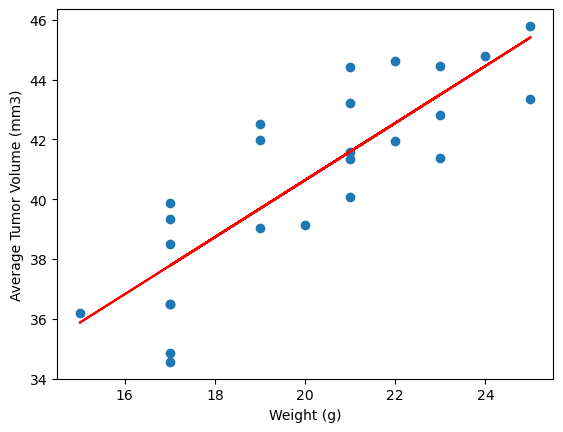

In [41]:
plt.scatter(x=capomulin_average['Weight (g)'],
            y=capomulin_average['Tumor Volume (mm3)'])
plt.plot(capomulin_average['Weight (g)'],
         y,
         color='red')
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)');

---